In [138]:
#Q1
import numpy as np
import copy

DEFAULT_CONT = 1

def get_open_spaces(board):
    open_spaces = []
    for i in range(len(board)):
        for j in range(len(board[i])):
            if (board[i][j] == 0):
                open_spaces.append((i,j))
    return open_spaces

def is_winner(board, circle=True):
    goal = len(board)
    if (not circle):
        goal *= -1

    # Check rows
    for i in range(len(board)):
        if (sum(board[i]) == goal):
            return True

    # Check cols
    for i in range(len(board[i])):
        if (sum(board[:,i]) == goal):
            return True

    # Check diagonal
    d1 = [board[x][x] for x in range(len(board))]
    d2 = [board[x][len(board)-x-1] for x in range(len(board))]
    if (sum(d1) == goal or sum(d2) == goal):
        return True

    return False

def get_reward(board, num_open_spaces, cont):
    if (is_winner(board, True)): # Player wins
        return 10
    if (is_winner(board, False)): # Opponent wins
        return -10
    if (num_open_spaces == 0):
        return 0
    return cont

def random_move(board, open_spaces, isplayer):
    if isplayer:
        marker = 1
    else:
        marker = -1
    index = np.random.randint(0, len(open_spaces))
    board[open_spaces[index]] = marker

def calculate_rewardtogo(reward, discount):
    rewardtogo = [0. for i in range(len(reward))] 
    for i in range(len(reward)):
        for j in range(i, len(reward)):
            rewardtogo[i] += reward[j] * discount ** (j-i)
    return rewardtogo

def MDP(board):
    states = []
    reward = [] # reward at each state
    player_turn = False
    while (True):
        open_spaces = get_open_spaces(board)
        r = get_reward(board, len(open_spaces), DEFAULT_CONT)
        if player_turn:
            states.append(copy.deepcopy(board))
            reward.append(r)
        if (r != 1): # Game over
            if r == 10:
                states.append(copy.deepcopy(board))
                #reward.append(r) state and reward before terminal cases
                
            break
        random_move(board, open_spaces, player_turn)
        if player_turn:
            player_turn = False
        else:
            player_turn = True
    return reward, states

init_board = np.zeros((3,3))
discount = 0.9
seeds = [0,1,2,3,4]
for i in range(len(seeds)):
    np.random.seed(seeds[i])
    board = copy.deepcopy(init_board)
    reward,states = MDP(board)
    rewardtogo = calculate_rewardtogo(reward, discount)
    print('TRAJECTORY\n', states)
    for i in range(len(rewardtogo)):
        print('State:')
        print(states[i])
        print('Reward to go: ', rewardtogo[i])
        print('')

                        

TRAJECTORY
 [array([[ 0.,  0.,  0.],
       [ 0.,  0., -1.],
       [ 0.,  0.,  0.]]), array([[ 1.,  0.,  0.],
       [ 0., -1., -1.],
       [ 0.,  0.,  0.]]), array([[ 1.,  0.,  0.],
       [ 0., -1., -1.],
       [ 1., -1.,  0.]]), array([[ 1.,  0., -1.],
       [ 0., -1., -1.],
       [ 1., -1.,  1.]]), array([[ 1.,  0., -1.],
       [ 1., -1., -1.],
       [ 1., -1.,  1.]])]
State:
[[ 0.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  0.  0.]]
Reward to go:  3.439

State:
[[ 1.  0.  0.]
 [ 0. -1. -1.]
 [ 0.  0.  0.]]
Reward to go:  2.71

State:
[[ 1.  0.  0.]
 [ 0. -1. -1.]
 [ 1. -1.  0.]]
Reward to go:  1.9

State:
[[ 1.  0. -1.]
 [ 0. -1. -1.]
 [ 1. -1.  1.]]
Reward to go:  1.0

TRAJECTORY
 [array([[ 0.,  0.,  0.],
       [ 0.,  0., -1.],
       [ 0.,  0.,  0.]]), array([[ 0.,  0.,  0.],
       [ 1.,  0., -1.],
       [-1.,  0.,  0.]]), array([[ 1.,  0., -1.],
       [ 1.,  0., -1.],
       [-1.,  0.,  0.]]), array([[ 1.,  0., -1.],
       [ 1., -1., -1.],
       [-1.,  0.,  1.]])]
State:
[[ 0. 

In [91]:
def get_all_states(board, all_states, turn, cont):
    skip = False
    if turn:
        board_str = np.array2string(board)
        if board_str in all_states:
            skip = True
        else:
            all_states[board_str] = copy.deepcopy(board)
    open_spaces = get_open_spaces(board)
    r = get_reward(board, len(open_spaces), cont)
    if r == cont or not skip: # Game is not over
        for i in open_spaces:
            if turn:
                board[i] = 1
            else:
                board[i] = -1
            get_all_states(copy.deepcopy(board), all_states, not turn, cont)
            board[i] = 0


In [148]:
import collections


def value_iteration(init_board, discount, cont):
    all_states = {}
    board = copy.deepcopy(init_board)
    get_all_states(board, all_states, False, cont)

    new_values = {k:0 for k in all_states}
    it = 0
    # start from 0
    res = collections.defaultdict(lambda:[0])
    while (True):
        values = copy.deepcopy(new_values)
        delta = 0
        for s in all_states.keys():
            curr_state = copy.deepcopy(all_states[s])
            open_spaces = get_open_spaces(curr_state)
            r = get_reward(curr_state, len(open_spaces), cont)
  

            best_action = 0.
            if r == cont:
                for i in range(len(open_spaces)):
                    curr_action = 0.
                    num_pos = 0.
                    for j in range(len(open_spaces)):
                        if (i != j):
                            num_pos += 1
                            player_move = open_spaces[i]
                            opponent_move = open_spaces[j]
                            tmp_state = copy.deepcopy(curr_state)
                            tmp_state[player_move] = 1
                            tmp_state[opponent_move] = -1
                            board_str = np.array2string(tmp_state)
                            if (board_str in values):
                                curr_action += values[board_str]
                    curr_action = curr_action / num_pos
                    if (curr_action > best_action):
                        best_action = curr_action 
            # Set updated value
            new_values[s] = r + discount * best_action
      
            if res[s][-1] is None:
                continue
            res[s].append(new_values[s])

            value_change = abs(new_values[s] - values[s])
            if value_change < 0.1: # terminal cases reaches first for some states
                res[s].append(None)
            if value_change > delta:
                delta = abs(new_values[s] - values[s])

        if (delta < 0.1):
            break
        it += 1
    return res

In [133]:

board = copy.deepcopy(init_board)
target = np.array([[-1.,0.,-1.], [1.,1.,0.], [ -1.,  0., 0.]])
target_string = np.array2string(target)
values = value_iteration(board, discount, DEFAULT_CONT)


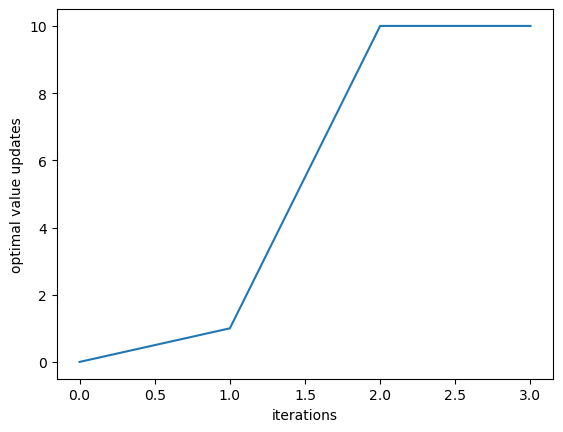

In [137]:
#Q2
target = np.array([[-1.,0.,-1.], [1.,1.,0.], [ -1.,  0., 0.]])
# the board in figure 1
target_string = np.array2string(target)

value_updates = values[target_string][:-1]

import matplotlib.pyplot as plt
plt.plot(value_updates)
plt.ylabel('optimal value updates')
plt.xlabel('iterations')
plt.show()


In [532]:
def get_open_spaces(s):
    open_spaces = []
    for i in range(len(s)):
        for j in range(len(s[i])):
            if (s[i][j] == 0):
                open_spaces.append((i,j))
    return open_spaces

def get_next_states(state,move):
    res = [] 
    s  = copy.deepcopy(state)
    i,j = move
    s[i][j] = 1
    if len(get_open_spaces(s)) == 0:
        res.append([s, 1])
        return res
    else:
        oppo_open_spaces = get_open_spaces(s)
        prob = 1 / len(oppo_open_spaces)
        for space in oppo_open_spaces:
            oppo_state = copy.deepcopy(s)
            i,j = space
            oppo_state[i][j] = -1
            res.append([oppo_state, prob])
    return res

def create_all_states(curr_state, all_states, V):
    curr_state = np.array(curr_state)
    state_string = np.array2string(curr_state)
    V[state_string] = [0, curr_state]
    all_states.append(curr_state)
    spaces = get_open_spaces(curr_state)
    if len(spaces) == 0:
        return all_states

    for space in spaces:
        
        new_state = copy.deepcopy(curr_state)
        
        i,j = space
        new_state[i][j] = 1

        
        if len(get_open_spaces(new_state)) == 0:
            V[np.array2string(new_state)] = [0, new_state]
            all_states.append(new_state)
            continue
        else:
            oppo_spaces = get_open_spaces(new_state)
            for oppo_space in oppo_spaces:
                oppo_state = list(copy.deepcopy(new_state))
                i,j = oppo_space
                oppo_state[i][j] = -1
                
                all_states = create_all_states(oppo_state, all_states, V)
    return all_states

def value_interation(state, tolerant, string_state):

    allStates = []
    new_V = {}
    create_all_states(state, allStates, new_V)
    num_iteration = 1
    graph = [0]
    target_action = None

    while True:
        V = copy.deepcopy(new_V)
        err = 0
        num_iteration += 1
        for state_string in V:
            curr_state = V[state_string][1]
            
            open_spaces = get_open_spaces(curr_state)
            scores = [0] * len(open_spaces)
            if not open_spaces:
                new_V[state_string] = [get_reward(curr_state,open_spaces,1), curr_state]
            else: 
                
                for i, space in enumerate(open_spaces):
                    next_state_w_prob = get_next_states(curr_state, space)
                    for ns_p in next_state_w_prob:
                        scores[i] += ns_p[1] * V[np.array2string(ns_p[0])][0]
        
                new_V[state_string][0] = get_reward(curr_state,open_spaces,1) + gamma * max(scores)
            
            
            
            if state_string == string_state:
                if abs(new_V[state_string][0]) <= 10:
                    graph.append(new_V[state_string][0])
                if scores and new_V[state_string][0] >= -10:
                    target_action  = open_spaces[scores.index(max(scores))]
                else:
                    target_action = None
                    
                
            if abs(new_V[state_string][0] - V[state_string][0]) > err:
                err = abs(new_V[state_string][0] - V[state_string][0])
        if err < tolerant:

            return graph, target_action


In [533]:
#Q3
S1_1 = np.array([[0, 0, 0], [0, 0, -1], [0, 0, 0]])
optimal_values, actions = value_interation(S1_1,0.1,np.array2string(S1_1))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)


optimal_v: 8.6878
action pos: (0, 0)


In [534]:
S1_2 = np.array([[1, 0, 0], [0, -1, -1], [0, 0, 0]])
optimal_values, actions = value_interation(S1_2,0.1,np.array2string(S1_2))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 8.541999999999998
action pos: (1, 0)


In [367]:
S1_3 = np.array([[1, 0, 0], [0, -1, -1], [1, -1, 0]])
optimal_values, actions = value_interation(S1_3,0.1,np.array2string(S1_3))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 10.0
action pos: (1, 0)


In [368]:
S1_4 = np.array([[1, 0, -1], [0, -1, -1], [1, -1, 1]])
optimal_values, actions = value_interation(S1_3,0.1,np.array2string(S1_3))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 10.0
action pos: (1, 0)


In [369]:
S1_5 = np.array([[1, 0, -1], [1, -1, -1], [1, -1, 1]])
optimal_values, actions = value_interation(S1_5,0.1,np.array2string(S1_5))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 10.0
action pos: (0, 1)


In [373]:
S2_1 = np.array([[0, 0, 0], [0, 0, 0], [0, 0, -1]])
optimal_values, actions = value_interation(S2_1,0.1,np.array2string(S2_1))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 8.6878
action pos: (1, 1)


In [376]:
S2_2 = np.array([[0, 0, 0], [0, 0, -1], [0, 1, -1]])
optimal_values, actions = value_interation(S2_2,0.1,np.array2string(S2_2))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 6.562
action pos: (1, 1)


In [377]:
S2_3 = np.array([[1, 0, 0], [0, -1, -1], [0, 1, -1]])
optimal_values, actions = value_interation(S2_3,0.1,np.array2string(S2_3))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 4.27
action pos: (0, 2)


In [378]:
S2_4 = np.array([[1, -1, 0], [1, -1, -1], [0, 1, -1]])
optimal_values, actions = value_interation(S2_4,0.1,np.array2string(S2_4))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 10.0
action pos: (2, 0)


In [380]:
S3_1 = np.array([[0, 0, 0], [0, 0, 0], [0, 0, -1]])
optimal_values, actions = value_interation(S3_1,0.1,np.array2string(S3_1))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 8.6878
action pos: (1, 1)


In [381]:
S3_2 = np.array([[0, 1, 0], [0, -1, 0], [0, 0, -1]])
optimal_values, actions = value_interation(S3_2,0.1,np.array2string(S3_2))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 7.948
action pos: (0, 0)


In [383]:
S3_3 = np.array([[1, 1, -1], [0, -1, 0], [0, 0, -1]])
optimal_values, actions = value_interation(S3_3,0.1,np.array2string(S3_3))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 4.27
action pos: (2, 0)


In [388]:
S3_4 = np.array([[1, 1, -1], [1, -1, 0], [-1, 0, -1]])
optimal_values, actions = value_interation(S3_4,0.1,np.array2string(S3_4))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: -10.0
action pos: None


In [389]:
S4_1 = np.array([[1, 0, 0], [0, -1, 0], [-1, 0, 0]])
optimal_values, actions = value_interation(S4_1,0.1,np.array2string(S4_1))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 8.541999999999998
action pos: (0, 2)


In [391]:
S4_2 = np.array([[1, 0, 0], [0, -1, 0], [-1, 1, -1]])
optimal_values, actions = value_interation(S4_2,0.1,np.array2string(S4_2))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 7.569999999999999
action pos: (0, 2)


In [393]:
S4_3 = np.array([[1, 0, 1], [0, -1, -1], [-1, 1, -1]])
optimal_values, actions = value_interation(S4_3,0.1,np.array2string(S4_3))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 10.0
action pos: (0, 1)


In [394]:
S5_1 = np.array([[0, 0, 0], [-1, 0, 0], [0, 0, 0]])
optimal_values, actions = value_interation(S5_1,0.1,np.array2string(S5_1))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 8.687800000000003
action pos: (0, 2)


In [397]:
S5_2 = np.array([[0, 0, -1], [-1, 0, 1], [0, 0, 0]])
optimal_values, actions = value_interation(S5_2,0.1,np.array2string(S5_2))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: 7.219
action pos: (1, 1)


In [411]:
S5_4 = np.array([[1, 0, -1], [-1, -1, 1], [0, -1, 1]])
optimal_values, actions = value_interation(S5_4,0.1,np.array2string(S5_4))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: -8.0
action pos: (0, 1)


In [417]:
S5_5 = np.array([[1, -1, -1], [-1, -1, 1], [1, -1, 1]])
optimal_values, actions = value_interation(S5_5,0.1,np.array2string(S5_5))
print("optimal_v:",optimal_values[-1])
print("action pos:",actions)

optimal_v: -10
action pos: None


In [526]:
def value_interation_returns_all_actions(state, tolerant, string_state):

    allStates = []
    new_V = {}
    create_all_states(state, allStates, new_V)
    num_iteration = 1
    graph = [0]
    action = {}

    while True:
        V = copy.deepcopy(new_V)
        err = 0
        num_iteration += 1
        for state_string in V:
            curr_state = V[state_string][1]
            
            open_spaces = get_open_spaces(curr_state)
            scores = [0] * len(open_spaces)
            if not open_spaces:
                new_V[state_string] = [get_reward(curr_state,open_spaces,1), curr_state]
            else: 
                
                for i, space in enumerate(open_spaces):
                    next_state_w_prob = get_next_states(curr_state, space)
                    for ns_p in next_state_w_prob:
                        scores[i] += ns_p[1] * V[np.array2string(ns_p[0])][0]
        
                new_V[state_string][0] = get_reward(curr_state,open_spaces,1) + gamma * max(scores)
            if state_string == string_state:
                if abs(new_V[state_string][0]) <= 10:
                    graph.append(new_V[state_string][0])
            if scores and new_V[state_string][0] >= -10:
                action[state_string]  = open_spaces[scores.index(max(scores))]
            else:
                action[state_string] = None
                    
                
            if abs(new_V[state_string][0] - V[state_string][0]) > err:
                err = abs(new_V[state_string][0] - V[state_string][0])
        if err < tolerant:

            return graph, action

In [527]:
import random
def gen_traj(state,actions):
    s = copy.deepcopy(state)
    states = [s]
    is_player = True
    open_spaces = get_open_spaces(s)
    while not (is_winner(s,True) or is_winner(s,False) or len(open_spaces)==0):
        
        if not is_player:
            oppo_pos = random.choice(open_spaces)
            i,j = oppo_pos 
            s[i][j] = -1
            new_s = copy.deepcopy(s)
            states.append(new_s)
        else:
            pos = actions[np.array2string(s)]
            if pos:
                i,j = pos 
                s[i][j] = 1
            
        
        is_player = not is_player
        open_spaces = get_open_spaces(s)
        
    if not is_player:
        states.append(s)

    rewards = []
    for s in states:
        open_spaces = get_open_spaces(s)
        rewards.append(get_reward(s,open_spaces, 1))
    R = calculate_rewardtogo(rewards,0.9)[1]
    return R

In [528]:
Q5_1 = np.array([[-1, 0, 0], [0, 0, 0], [0, 0, 0]])
optimal_values, actions = value_interation_returns_all_actions(Q5_1,0.1,np.array2string(Q5_1))


Text(0.5, 0, 'k')

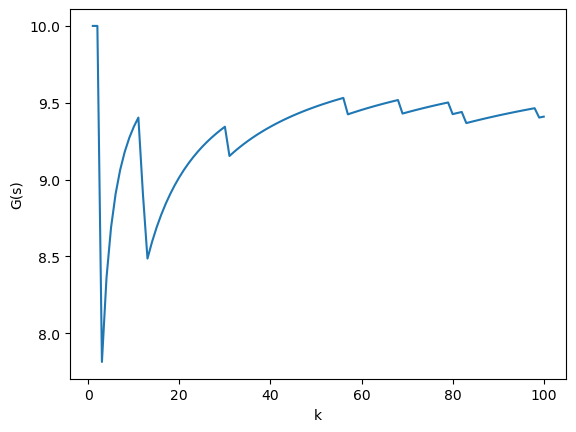

In [529]:
reward_to_go = []
for k in range(100):
    reward_to_go.append(gen_traj(Q5_1,actions))
ks = []
for k in range(1, 101):
    ks.append(sum(reward_to_go[:k]) / k)

plt.plot(np.arange(1, 101), ks)
plt.ylabel('G(s)')
plt.xlabel('k')

In [ ]:
#Q7

In [620]:
import random
import numpy as np

out_of_grid_penalty = -100
end_row = 6


alpha = 0.8
gamma = 0.9
epsilon = 0.2

def move(state, action):
    if action == 0:
        if state[0] + 1 <=end_row :
            return [state[0] + 1, state[1]]
    if action == 1:
        if state[0] + 2 <= end_row:
            return [state[0] + 2, state[1]]
    if action == 2:
        if state[0] + 1 <= end_row:
            if state[1] == 0:
                return [state[0] + 1, 1]
            elif state[1] == 1:
                return [state[0] + 1, 0]
    return None   

def get_reward(state):
    if state[0] == end_row:
        return 10
    else:
        return -1

def get_all_states():
    states = []
    Q_values = {}
    for i in range(7):
        for j in range(2):
            states.append([i, j])
            Q_values[str([i, j])] = [0, 0, 0]
    return states, Q_values




def get_Q_values(Q_values):
    for i in range(100000):

        i = 0
        j = random.randint(0, 1)
        state = [i,j] #start from the start row
        reward = 0

        while True:
            state_val = str(state)
            reward = get_reward(state)
            if state[0] == end_row: # reach to target cell
                Q_values[state_val] = [reward]*3
                break
            if random.uniform(0, 1) < epsilon:
                action = random.randint(0, 2) # random move
            else:
                action = Q_values[state_val].index(max(Q_values[state_val])) #move with best move

            next_state = move(state, action)
            if not next_state: #mostly prevent to drive out two lane
                 next_max_q = out_of_grid_penalty 
            else:
                next_max_q = max(Q_values[str(next_state)])
                
            old_q = Q_values[state_val][action]
            new_q = old_q + alpha * (reward + gamma * next_max_q - old_q)
            Q_values[state_val][action] = new_q
            
            if next_state: state = next_state
            else: break
    return Q_values

states, Q_values = get_all_states()
d1_str = str([3,0])
q_action_1,q_action_2,q_action3 = get_Q_values(Q_values)[d1_str]
print(q_action_1,q_action_2,q_action3)



6.2 6.2 6.2


In [633]:
alpha = 0.8
gamma = 0.9
epsilon = 0.2
hit_penalty = -1000

def move_w_pedestrian(state, action, hit):
    state[2] -= 1
    state[3] += 1
    
    if state[2] < 0: state[2] = -1
    if state[3] > 7: state[3] = -1
        
    
    if action == 0 or action == 1: # one block
        if state[0] + 1 <=end_row :
            curr_state = state[0] + 1
            if curr_state == 3 and state[2] - 3 == state[1]: 
                #print(curr_state, state[1],state[2],state[3])
                hit = True
            elif curr_state == 4 and state[3] - 3 == state[1]: hit = True
            else:
                if action == 0:
                    return [ curr_state, state[1],state[2],state[3]], False
        
    if action == 1: # two blocks
        if state[0] + 1 <= end_row:
            curr_state = state[0] + 1
            if curr_state == 3 and state[2] - 3 == state[1]: hit = True
            elif curr_state == 4 and state[3] - 3 == state[1]: hit = True
            else:return [curr_state, state[1],state[2],state[3]],False
    if action == 2:
        if state[0] + 1 <= end_row:
            if state[1] == 0:
                curr_state = state[0] + 1
                if curr_state == 3 and state[2] - 3 == 1: hit = True
                elif curr_state == 4 and state[3] - 3 == 1: hit = True
                else: return [curr_state, 1, state[2],state[3]],False
            elif state[1] == 1:
                curr_state = state[0] + 1
                if curr_state == 3 and state[2] - 3 == 0: hit = True
                elif curr_state == 4 and state[3] - 3 == 0: hit = True
                else: return [curr_state, 0, state[2],state[3]],False
        
            
    return None,hit 

def get_all_states_w_pedestrian():
    states = []
    Q_values = {}
    for i in range(7):
        for j in range(2):
            for p1 in range(-1, 8):
                for p2 in range(-1, 8):
                    states.append([i, j,p1,p2])
                    Q_values[str([i, j,p1,p2])] = [0, 0, 0]
    return states, Q_values

def get_Q_values_w_pedestrian(Q_values):
    for i in range(1000000):

        i = random.randint(0, 6)
        j = random.randint(0, 1)
        p1 = random.randint(0, 7)
        p2 = random.randint(0, 7)
        state = [i,j,p1,p2] #start from the start row
        reward = 0
        hit = False
        
        while True:
            state_val = str(state)
            reward = get_reward(state)
            if state[0] == end_row: # reach to target cell
                Q_values[state_val] = [reward]*3
                break
            if random.uniform(0, 1) < epsilon:
                action = random.randint(0, 2) # random move
            else:
                action = Q_values[state_val].index(max(Q_values[state_val])) #move with best move

            next_state, hit = move_w_pedestrian(state, action, hit)
            if not next_state: #mostly prevent to drive out two lane
                if not hit:
                    next_max_q = out_of_grid_penalty 
                else:
                    #print(state,next_state, action)
                    next_max_q = hit_penalty 
            else:
                next_max_q = max(Q_values[str(next_state)])
                
            old_q = Q_values[state_val][action]
            new_q = old_q + alpha * (reward + gamma * next_max_q - old_q)
            Q_values[state_val][action] = new_q
            
            if next_state: state = next_state
            else: break # going off grid OR hit
    return Q_values

states, Q_values = get_all_states_w_pedestrian()
updated_qs = get_Q_values_w_pedestrian(Q_values)



In [634]:
q_a_1,q_a_2,q_a_3 = 0,0,0
for i in range(-1,8):
    for j in range(-1,8):
        #d1_str = str([3,0,i,j])
        d1_str = str([3,0,0,2])
        q_action_1,q_action_2,q_action_3 = updated_qs[d1_str]
        
        print(q_action_1,q_action_2,q_action_3)

-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.0 4.58
-901.0 -901.